In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve,
    average_precision_score)

np.random.seed(123)

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

In [3]:
train = train.drop(columns=["Customer Status_inactive", "Customer Status"], errors="ignore")
test  = test.drop(columns=["Customer Status_inactive", "Customer Status"], errors="ignore")

train["Support Calls"] = pd.to_numeric(train["Support Calls"].replace("none", 0), errors="coerce").fillna(0).astype(int)
test["Support Calls"]  = pd.to_numeric(test["Support Calls"].replace("none", 0), errors="coerce").fillna(0).astype(int)

train["Payment Delay"] = pd.to_numeric(train["Payment Delay"].replace("none", 0), errors="coerce")
test["Payment Delay"]  = pd.to_numeric(test["Payment Delay"].replace("none", 0), errors="coerce")

In [4]:
numeric_cols = ["Age", "Tenure", "Usage Frequency", "Support Calls", "Payment Delay", "Total Spend", "Last Interaction"]
for col in numeric_cols:
    train[col] = train[col].fillna(train[col].median())
    test[col]  = test[col].fillna(train[col].median())

In [5]:
train["Last Interaction"] = train["Last Interaction"].fillna(train["Last Interaction"].median())
test["Last Interaction"]  = test["Last Interaction"].fillna(train["Last Interaction"].median())

train['Spend_per_Usage'] = train['Total Spend'] / (train['Usage Frequency'] + 1)
test['Spend_per_Usage']  = test['Total Spend']  / (test['Usage Frequency']  + 1)

train['High_Usage_High_Spend'] = ((train['Usage Frequency'] > train['Usage Frequency'].median()) &
                                  (train['Total Spend'] > train['Total Spend'].median())).astype(int)
test['High_Usage_High_Spend']  = ((test['Usage Frequency'] > train['Usage Frequency'].median()) &
                                  (test['Total Spend'] > train['Total Spend'].median())).astype(int)

train['Recency_per_Tenure'] = train['Last Interaction'] / (train['Tenure'] + 1)
test['Recency_per_Tenure']  = test['Last Interaction']  / (test['Tenure'] + 1)

train['Late_Payment'] = (train['Payment Delay'] > train['Payment Delay'].median()).astype(int)
test['Late_Payment']  = (test['Payment Delay']  > train['Payment Delay'].median()).astype(int)

derived = ['Spend_per_Usage','High_Usage_High_Spend','Recency_per_Tenure','Late_Payment']
for c in derived:
    train[c] = train[c].fillna(0)
    test[c]  = test[c].fillna(0)

In [6]:
train_ids = train["CustomerID"] if "CustomerID" in train.columns else None
test_ids  = test["CustomerID"]  if "CustomerID"  in test.columns  else None

train = train.drop(columns=["CustomerID","Last Due Date","Last Payment Date"], errors="ignore")
test  = test.drop(columns=["CustomerID","Last Due Date","Last Payment Date"], errors="ignore")

train = train.drop(columns=["Payment Delay", "Late_Payment"])
test = test.drop(columns=["Payment Delay", "Late_Payment"])

In [7]:
categorical_cols = ["Gender", "Subscription Type", "Contract Length"]
train = pd.get_dummies(train, columns=categorical_cols, drop_first=True)
test  = pd.get_dummies(test,  columns=categorical_cols, drop_first=True)

In [8]:
feature_cols = train.drop(columns=["Churn"]).columns
test = test.reindex(columns=feature_cols, fill_value=0)

In [9]:
X = train.drop("Churn", axis=1)
y = train["Churn"].astype(int)

In [10]:
numeric_cols = [col for col in X.columns if X[col].dtype in ['int64','float64']]
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=123, stratify=y)

In [11]:
scaler = StandardScaler()
scaler.fit(X_train[numeric_cols])

X_train_scaled = X_train.copy()
X_val_scaled   = X_val.copy()
X_test_scaled  = test.copy()
X_train_scaled[numeric_cols] = scaler.transform(X_train[numeric_cols])
X_val_scaled[numeric_cols]   = scaler.transform(X_val[numeric_cols])
X_test_scaled[numeric_cols]  = scaler.transform(X_test_scaled[numeric_cols])

In [12]:
for col in numeric_cols:
    X_train_scaled[col] = X_train_scaled[col].fillna(X_train_scaled[col].median())
    X_val_scaled[col]   = X_val_scaled[col].fillna(X_train_scaled[col].median())
    X_test_scaled[col]  = X_test_scaled[col].fillna(X_train_scaled[col].median())

In [13]:
leaks = []
for col in X.columns:
    try:
        score = roc_auc_score(y, X[col])
        if score > 0.98:
            leaks.append((col, score))
    except Exception:
        pass

In [14]:
y_pred_baseline = np.where(X_val["Support Calls"] > 3, 1, 0)
y_prob_baseline = np.where(X_val["Support Calls"] > 3, 0.9, 0.1)

In [15]:
best_k = 1
best_f1 = -1
for k in range(1, 31, 2):
    knn_tmp = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn_tmp.fit(X_train_scaled, y_train)
    y_pred_tmp = knn_tmp.predict(X_val_scaled)
    f1_tmp = f1_score(y_val, y_pred_tmp)
    if f1_tmp > best_f1:
        best_f1 = f1_tmp
        best_k = k

In [16]:
knn = KNeighborsClassifier(n_neighbors=best_k, weights='distance')
knn.fit(X_train_scaled, y_train)
y_prob_knn = knn.predict_proba(X_val_scaled)[:, 1]
y_pred_knn = (y_prob_knn > 0.5).astype(int)


In [17]:
dt = DecisionTreeClassifier(class_weight="balanced", random_state=123, max_depth=5, min_samples_leaf=100)
dt.fit(X_train_scaled, y_train)
y_prob_dt = dt.predict_proba(X_val_scaled)[:, 1]
best_thresh = 0.63
y_pred_dt = (y_prob_dt > best_thresh).astype(int)

In [18]:
def model_metrics(y_true, y_pred, y_prob=None):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "specificity": tn / (tn + fp),
        "f1": f1_score(y_true, y_pred)}
    if y_prob is not None:
        metrics["roc_auc"] = roc_auc_score(y_true, y_prob)
        metrics["avg_precision"] = average_precision_score(y_true, y_prob)
    return metrics

In [19]:
models = {
    "Baseline": (y_pred_baseline, y_prob_baseline),
    f"k-NN (k={best_k})": (y_pred_knn, y_prob_knn),
    "Decision Tree": (y_pred_dt, y_prob_dt)}

In [20]:
metrics_df = pd.DataFrame()
for name, (y_pred, y_prob) in models.items():
    metrics_df[name] = model_metrics(y_val, y_pred, y_prob)
metrics_df = metrics_df.T
print(metrics_df)
print(pd.Series(dt.feature_importances_, index=X_train_scaled.columns).sort_values(ascending=False).head(20))

               accuracy  precision    recall  specificity        f1   roc_auc  \
Baseline       0.771416   0.642462  0.536747     0.871986  0.584866  0.704366   
k-NN (k=11)    0.853900   0.761013  0.747846     0.899351  0.754372  0.897757   
Decision Tree  0.881711   0.754984  0.896705     0.875285  0.819764  0.908951   

               avg_precision  
Baseline            0.483814  
k-NN (k=11)         0.744976  
Decision Tree       0.774603  
Support Calls                 0.359851
Total Spend                   0.315957
Contract Length_Monthly       0.182623
Age                           0.131357
Gender_Male                   0.007891
Tenure                        0.001222
Usage Frequency               0.000861
Spend_per_Usage               0.000185
Recency_per_Tenure            0.000054
Last Interaction              0.000000
High_Usage_High_Spend         0.000000
Subscription Type_Premium     0.000000
Subscription Type_Standard    0.000000
Contract Length_Quarterly     0.000000
dtype

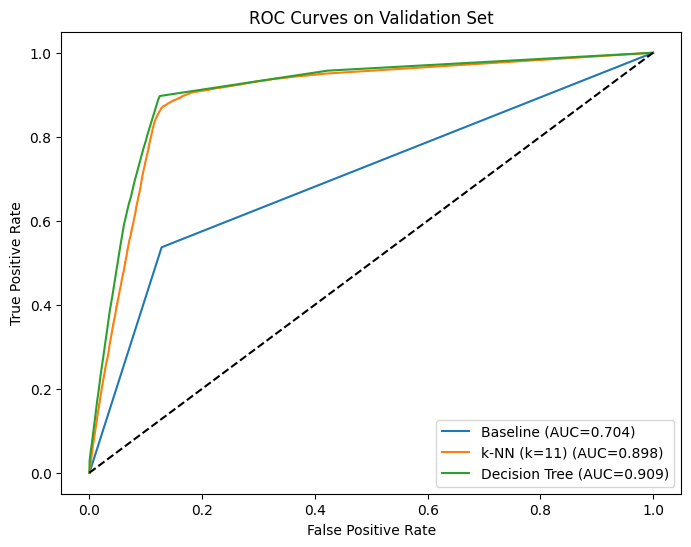

In [21]:
plt.figure(figsize=(8,6))
for name, (_, y_prob) in models.items():
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    auc = roc_auc_score(y_val, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves on Validation Set")
plt.legend()
plt.show()

In [22]:
test_preds = knn.predict(X_test_scaled)
submission = pd.DataFrame({"CustomerID": test_ids, "Churn": test_preds})
submission.to_csv("submission.csv", index=False)
print("Saved submission.csv")

Saved submission.csv


In [23]:
print(pd.Series(submission['Churn']).value_counts())
print(pd.Series(y_pred_dt).value_counts())
print(precision_score(y_val, y_pred_dt))
print(recall_score(y_val, y_pred_dt))
print(f1_score(y_val, y_pred_dt))
print(average_precision_score(y_val, y_prob_dt))

Churn
1    91659
0    42117
Name: count, dtype: int64
0    58536
1    32402
Name: count, dtype: int64
0.75498426023085
0.8967046662512371
0.8197644220297237
0.7746025178503518
